In [7]:
import os
import pathlib

In [18]:
from astropy import visualization as aviz
from astropy.nddata.blocks import block_reduce
from astropy.nddata.utils import Cutout2D
from matplotlib import pyplot as plt

In [47]:
def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    
    return fig

In [20]:
test_file = "2022_03_20/Dark/Dark_0.003_secs_002.fits"

In [26]:
from astropy.io import fits
from astropy.nddata import CCDData

In [27]:
with fits.open(test_file) as hdul:
    hdul.info()

Filename: 2022_03_20/Dark/Dark_0.003_secs_002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (4656, 3520)   int16 (rescales to uint16)   


In [32]:
file_path = "./2022_03_20/Dark"

In [36]:
len(os.listdir(file_path))

95

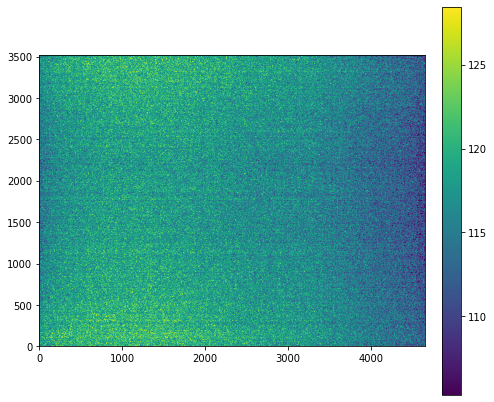

In [38]:
plot_file = CCDData.read(test_file, unit='adu')
show_image(plot_file)

IndexError: index 3 is out of bounds for axis 1 with size 3

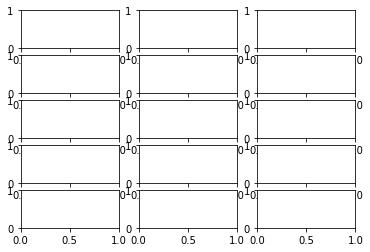

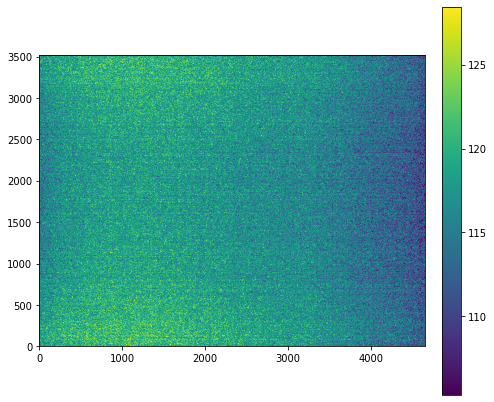

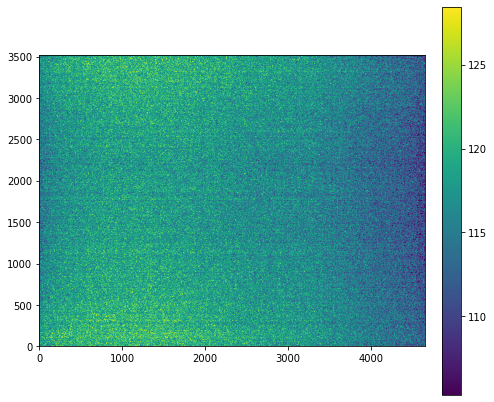

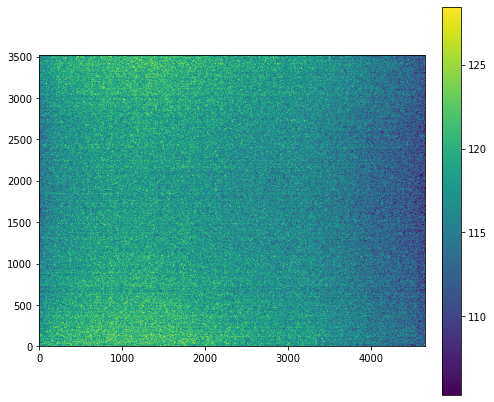

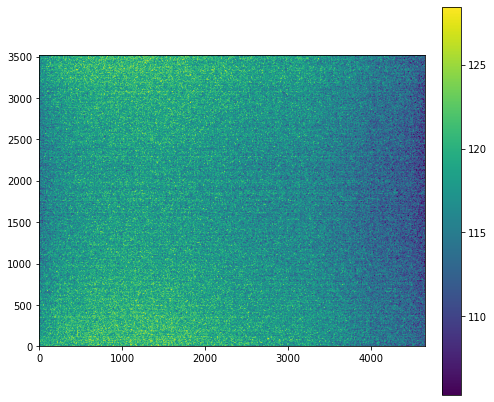

In [42]:
fig, axs = plt.subplots(5, 3)
for index, file in enumerate(os.listdir(file_path)[:14]): 
    file = "./2022_03_20/Dark/" + file
    file_to_plot = CCDData.read(file, unit='adu')
    row = index
    while row > 4: # very unorthodox, but makes index 5 onwwards map onto 0, 1, 2, 3 and 4
        row -= 5
    column = index
    while row > 2: # very unorthodox, but makes index 5 onwwards map onto 0, 1, 2, 3 and 4
        row -= 3
    axs[row, column] = show_image(file_to_plot)

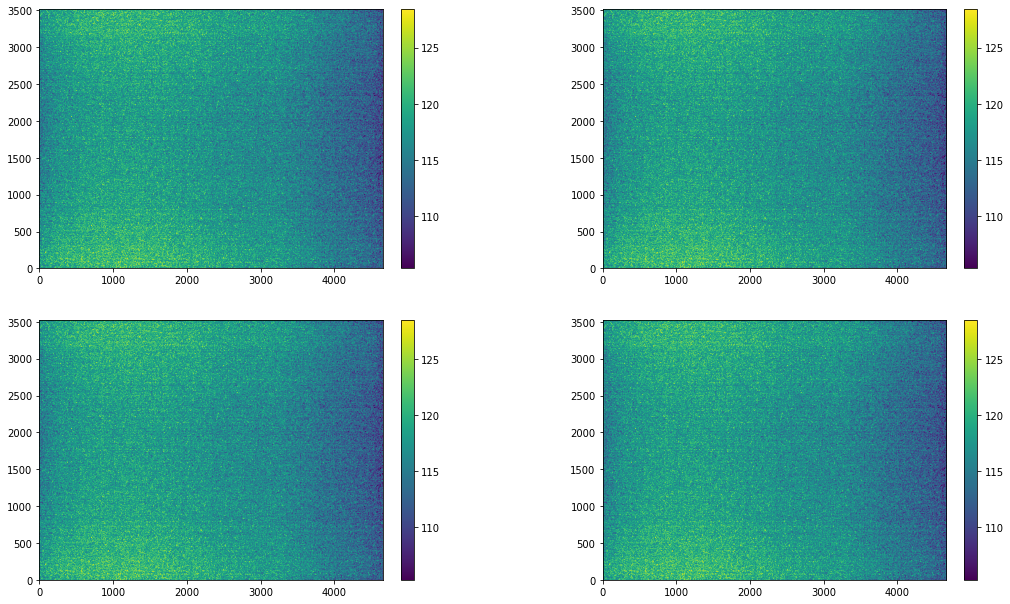

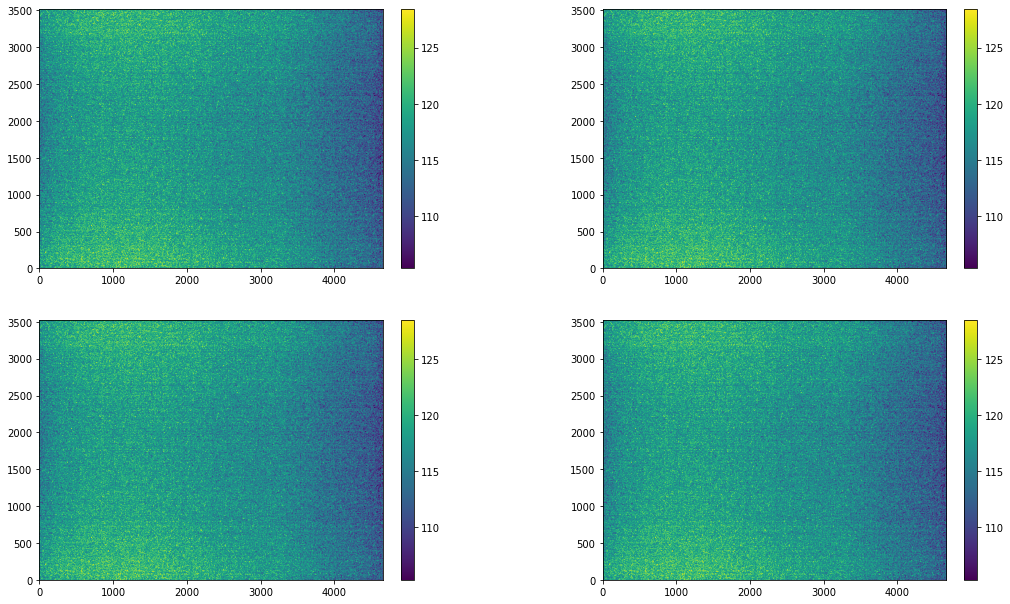

In [59]:
from matplotlib.pyplot import figure

fig, axs = plt.subplots(2, 2)
file_1 = "2022_03_20/Dark/Dark_0.003_secs_001.fits"
file_2 = "2022_03_20/Dark/Dark_0.003_secs_002.fits"
file_3 = "2022_03_20/Dark/Dark_0.003_secs_003.fits"
file_4 = "2022_03_20/Dark/Dark_0.003_secs_004.fits"

fig.set_size_inches(18.5, 10.5)

plot_file_1 = CCDData.read(file_1, unit='adu')
plot_file_2 = CCDData.read(file_2, unit='adu')
plot_file_3 = CCDData.read(file_3, unit='adu')
plot_file_4 = CCDData.read(file_4, unit='adu')

show_image(plot_file_1, fig = fig, ax = axs[0,0])
show_image(plot_file_1, fig = fig, ax = axs[1,0])
show_image(plot_file_1, fig = fig, ax = axs[0,1])
show_image(plot_file_1, fig = fig, ax = axs[1,1])